# Time Seriees

## What Time Series Analysis Actually Is

Time Series Analysis (TSA) is the process of analysing data points collected at regular time intervals to uncover meaningful patterns, behaviours, and structure that can help us understand the past and forecast the future.

At its core, TSA assumes that the past contains useful information about the future. In practice, this means each new observation is, to some degree, autocorrelated with previous observations — today's value is not independent of yesterday's value.

This idea of temporal dependence (how far back past observations continue to influence the present) is what underpins modern forecasting techniques and has driven much of the innovation we see today across data science, econometrics, and machine learning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

## Download data
This is from Kaggle (French Bakery Daily Sales)

In [84]:
df = pd.read_csv("../datasets/daily_sales_french_bakery.csv", parse_dates=["ds"])
# Drop anything with less than 28 days of data
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df = df.drop(["unit_price"], axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


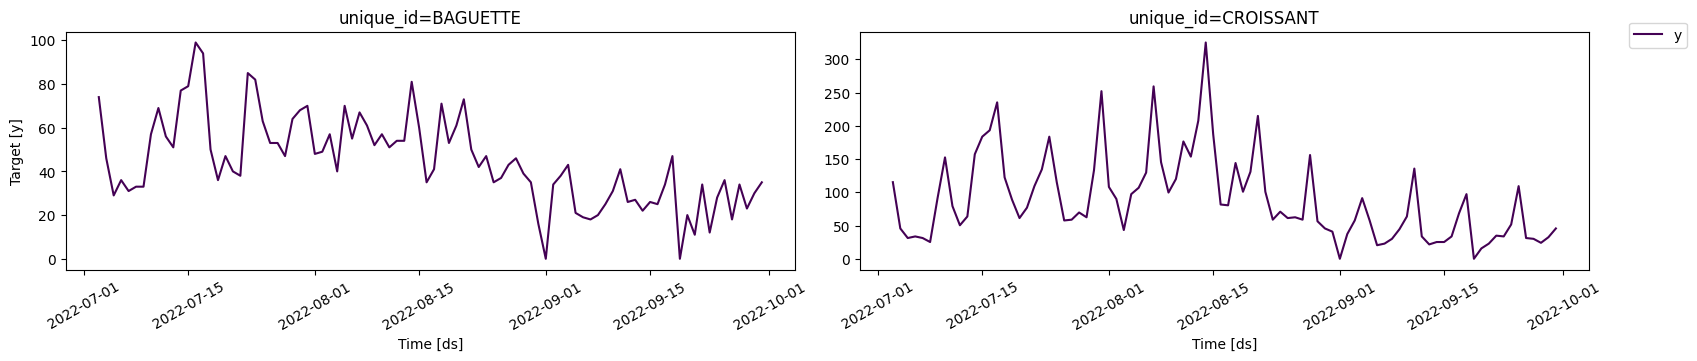

In [85]:
last_90_days = plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=90, palette="viridis")
last_90_days

## Benchmarking

Simple statistical models are not particularly useful in real-life time series forecasting but are very helpful in establishing a benchmark to evaluate against complex models. 

At the end of the day, if your neural-network powered timeseries forecast model is only slightly better than basic statistics, you need to consider the cost-benefit in time (maintenance) and effort(compute) v. benefit(reliability uptick)

Simple stats 7 day forecast of daily data:
1. Naive --> yesterday
2. Window Avg --> avg. past week
3. Historic Avg --> avg. all time
4. Seasonal Naive --> repeat past week pattern

In [6]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [42]:
benchmark_models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

In [ ]:
# Often a business decision but will discuss later
horizon = 7


# 1. Select Models and indicate frequency of data
sf = StatsForecast(models=benchmark_models, freq="D")
# 2. Train the models on the 
sf.fit(df=df)
preds = sf.predict(h=horizon)

### What a Business Analyst will do

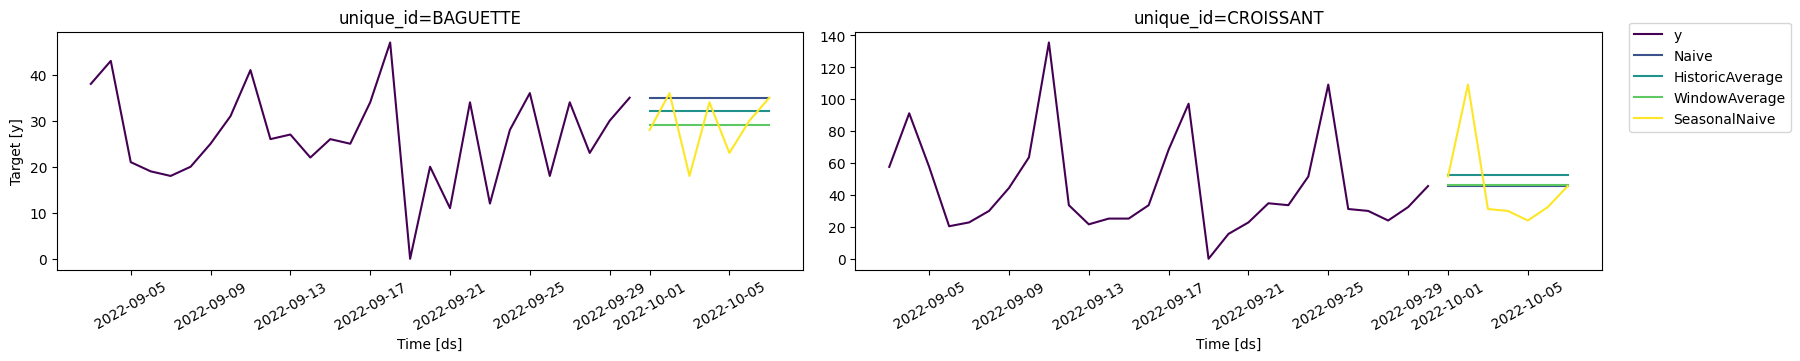

In [86]:
monkey_analysis = plot_series(
    df=df, 
    forecasts_df=preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28, 
    palette="viridis")

monkey_analysis

### Evaluation tracking
In time-series forecasting, we **never use a random train/test split** because it breaks the temporal structure. Instead, we split the dataset chronologically, preserving the true order of events.

When forecasting a fixed horizon — say 7 days (prediction length) — the rule is simple:
- Train ds = all observations up to the last 7 (based on timestamp)
- Test ds = the last 7 observations (based on timestamp)

This ensures that:
a. the model only learns from the past,
b. evaluation is fair (no leakage), and
c. the test set is a true simulation of “future” timestamps.

Best Metrics to get started:
- MAE (Mean Absolute Error)
- MAPE “on average, we’re off by X%" - works for both statistical and deep models

In [87]:
# 1. Select Models and indicate frequency of data
bm_predictor = StatsForecast(models=benchmark_models, freq="D")

#2. Split the dataset into testing and training
test_df = df.groupby("unique_id").tail(7)
train_df = df.drop(test_df.index).reset_index(drop=True)

# 2. Train the models on the train dataset
bm_predictor.fit(df=train_df)

# 3. Get the trained models to predict values over the test_df time period
preds_df = bm_predictor.predict(h=horizon)

# 4. Evaluate the results of the predicted values against the actual values in test_df
eval_df = pd.merge(test_df, preds_df, 'left', ['ds', 'unique_id'])
evaluation = evaluate(eval_df,metrics=[mae],)
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()

# 5. Interpret the results (lower is better)
evaluation.head()

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


Intepretation: use Seasonal Naive as a benchmark

## Statistical Models

With a baseline of simple stats established, we can now consider more advanced statistical models, namely:
1. ARIMA: flexible - any series with a trend and 1 seasonal pattern/period, support for exogenous features
2. SARIMA,MSTL, BATS, TBATS - >1 seasonal patterns/periods
3. Theta: decompositional
4. Croston, TSB: intermittent series - support for 0 and None value

**Stationarity?**
Most models have built-in handlers to manage non-stationarity, no manual transformations needed =) 

**Auto Forecasting**
Note: most of these models have an auto option - which automatically identifies the best param combinations for you, leaving you responsible for identifying the seasonal length

In [71]:
from statsforecast.models import AutoARIMA

### ARIMA

AR: autoregressive - future values depend on past values --> p (no. of past values)
MA: moving avg - future values depend on past error terms --> q (no. of past error)
I: order of integration --> i(0, 1, 2) (no differecing, 1st differencing, second differencing)

*ARMA is not really used as it requires stationary data i.e. no trend or seasonality. To use ARMA, you need to transform the data until it is stationary*

**AUTO-ARIMA**
Most models come with an 'auto' option - which automatically identifies the best param combinations for you, leaving you responsible for identifying the seasonal length

As AutoArima needs to find the optimal parameters, it's best to work with a smaller subset of your dataset first

In [73]:
unique_ids = ["BAGUETTE", "CROISSANT"]

train_df_sml = train_df[train_df["unique_id"].isin(unique_ids)]
test_df_sml = test_df[test_df["unique_id"].isin(unique_ids)]


### Determining seasonal length

Setting the season_length argument is sometimes tricky. Some ideas/tips:
1. Use domain knowledge (or common sense): ask yourself “How often should this system logically repeat?” --> simple/easier to get started
2. Advanced
   1. Visual FFT test: run fourier transform and convert frequenct to days --> look for big spikes (that is your season length).
   2. Residual test: run STL for several candidate periods (k = 5, 7, 24, 30…) --> pick the k that gives the lowest residual variance


In [74]:
from statsmodels.tsa.seasonal import STL

from plotnine import ggplot, aes, geom_line, labs, scale_x_log10, theme_minimal

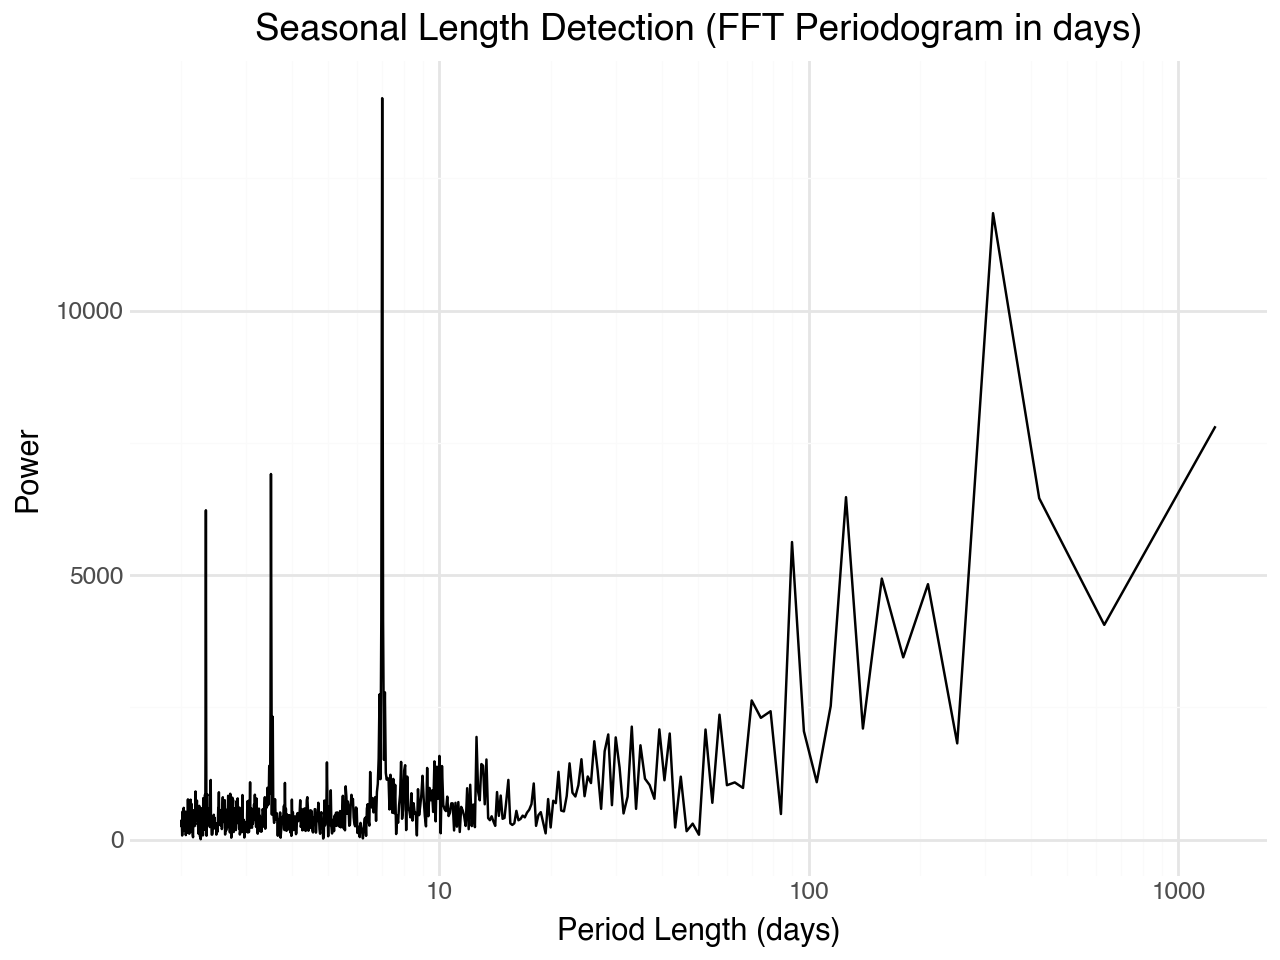

In [ ]:
def visualise_fft(ts):
    """
    Compute FFT and return a tidy dataframe of frequencies and powers.
    """
    n = len(ts)
    fft_vals = np.fft.fft(ts - ts.mean())
    fft_freq = np.fft.fftfreq(n)

    mask = fft_freq > 0
    df_fft = pd.DataFrame({
        "frequency": fft_freq[mask],
        "power": np.abs(fft_vals[mask])
    })
    
    df_fft["period"] = 1 / df_fft["frequency"]
    df_fft = df_fft.replace([np.inf, -np.inf], np.nan).dropna()

    p = (
        ggplot(df_fft, aes(x="period", y="power"))
        + geom_line()
        + scale_x_log10() 
        + labs(
            title="Seasonal Length Detection (FFT Periodogram in days)",
            x="Period Length (days)",
            y="Power"
        )
        + theme_minimal()
    )

    return p

ts = train_df_sml['y']
visual_fft_test = visualise_fft(ts)
visual_fft_test


Intepretation
- There is one very large spike around 7–8 days and is the strongest seasonal candidate in the entire plot.
- This strongly suggests the presence of a weekly cycle

Sequence Length: 7 days

In [45]:
seasonality_len = 7

The season length does NOT determine the length of your forecast horizon.
- Though, intuitively having shorter horizons (than season length) will generally increase accuracy as there is greater certainty.

In practise, horizons are divisible by the season length i.e. if season length is 7 days then horizon is 7, 14, 21, 28 etc. 
- Why? these horizons align perfectly with seasonal cycles.

In [49]:
arima_models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=seasonality_len, alias="SARIMA")
]

When we fit ts models, we typically need to provide the following params:
1. models: a list of models to fit
2. freq: a string indicating the time step (or frequency) between our data points e.g. "D" equals 1 day

In [ ]:
# 1. Select Models and indicate frequency of data
stat_predictor = StatsForecast(models=arima_models, freq="D")

#2. Split the dataset into testing and training - as AutoARIMA needs to find optimal params, it can take a while on large datasets (so we reduced it)

train_df_sml = train_df_sml
test_df_sml = test_df_sml

# 3. Train the models on the train dataset
stat_predictor.fit(df=train_df_sml)

# 3. Get the trained models to predict values over the test_df time period
arima_preds_df = stat_predictor.predict(h=horizon)

# 4. Evaluate the results of the predicted values against the actual values in test_df using the eval metric
# (inner join because so we're only comparing against the unique ids all models forecasted on) 
arima_eval_df = pd.merge(arima_preds_df, eval_df, 'inner', ['ds', 'unique_id'])
evaluation = evaluate(arima_eval_df,metrics=[mae],)
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()

# 5. Interpret the results (lower is better)
evaluation.head()



,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


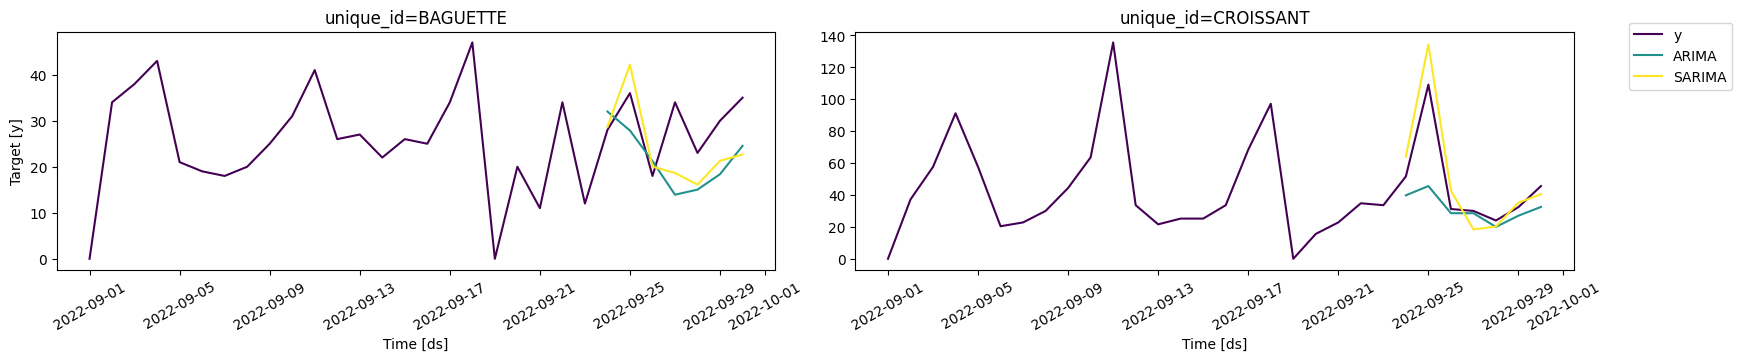

In [88]:
last_30_days = plot_series(
    df=df, 
    forecasts_df=arima_preds_df, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=30, 
    palette="viridis")
last_30_days


## Evaluation (Backtesting)

In practise, 1 test forecast against the past 7 days is not enough. You want to 'backtest' your model at multiple times within your time series to get a true sense for its forecast/predictive power and performance. 

Enter 'Cross-validation'

Note: when we say 'backtesting' we're specifically referring to rolling-origin time-series cross-validation - which is the default CV method in most libraries

In [ ]:
# Take the whole df as we don't need to test/train split
small_df = df[df["unique_id"].isin(unique_ids)]

arima_bm_models = [
    SeasonalNaive(season_length=7),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

predictor = StatsForecast(models=arima_bm_models, freq="D")

cv_df = predictor.cross_validation(
    h=horizon, 
    df=small_df,
    # Each window gives you 1 eval result. For seasonal models, a window should cover at least 2-3 seasons (season lengths). Most research suggests 8-12 windows
    n_windows=8,
    # If the horizon matters most (e.g. business requirement/sales request) step size = horizon, if seasonal structure matters most: step size = season_length
    step_size=horizon,
    refit=True
)

cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.355195,71.584714
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.337979,78.458884
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.195002,57.001733
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.649013,49.401145
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.785876,49.725279


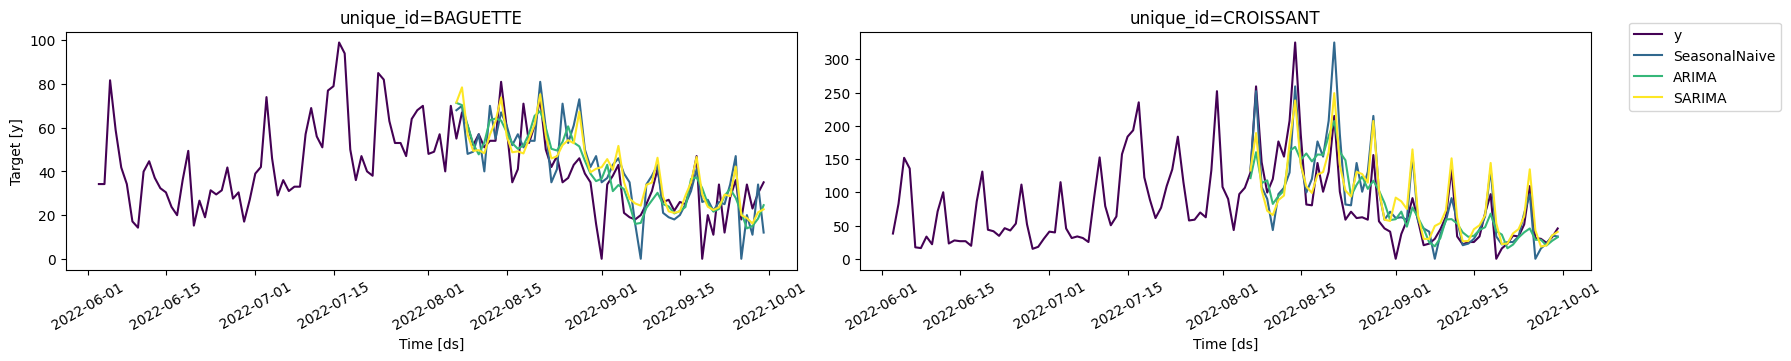

In [89]:
last_quarter = plot_series(
    df=small_df, 
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1), 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=120, 
    palette="viridis")

last_quarter

In [90]:
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.17093,19.281295


## Exogenous features

In real-life, we know that other things impact timeseries data. 

These are external drivers impacting your timeseries (indices, macro, holidays, events, other assets).

3 types:
1. Static Features: fixed over time e.g. product_id, category, office_id etc.
2. Past/Historical Features: values are only known in the past, not in the forecast horizon
3. Future Features: known in the past and the forecast horizon

In [93]:
# Lets capture the price (exogenous feature)
df = pd.read_csv("../datasets/daily_sales_french_bakery.csv", parse_dates=["ds"])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


In [95]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]

test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)
futr_exog_df = test.drop(["y"], axis=1)

In [96]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)
arima_exog_preds = sf.predict(h=7, X_df=futr_exog_df)

models = [
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train.drop(["unit_price"], axis=1))
arima_preds = sf.predict(h=horizon)

In [98]:
test_df = test.merge(arima_exog_preds, on=["unique_id", "ds"], how="left")\
              .merge(arima_preds, on=["unique_id", "ds"], how="left")

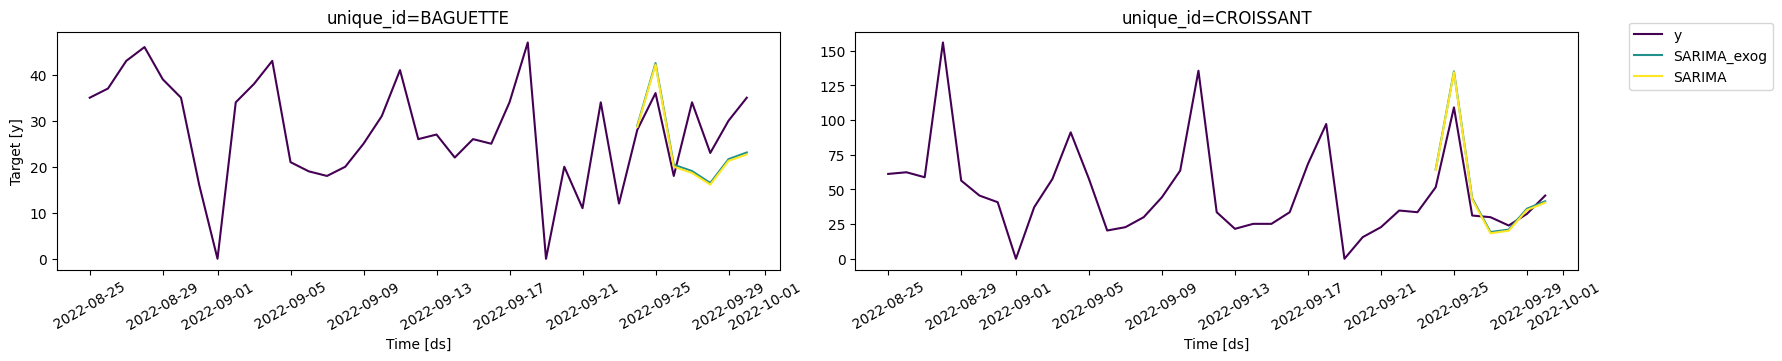

In [99]:
past_30_days_p = plot_series(
    df=train, 
    forecasts_df=test_df, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=30,
    models=["SARIMA_exog", "SARIMA"],
    palette="viridis"
)

past_30_days_p